In [1]:
import requests
import pandas as pd

# Load preprocessed soil dataset
soil_district_df = pd.read_csv('soil_data.csv')

# Define the Open Meteo API URL
BASE_URL = "https://api.open-meteo.com/v1/forecast"

# Function to fetch weather data for a given latitude and longitude
def fetch_weather_data(lat, lon):
    params = {
        "latitude": lat,
        "longitude": lon,
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,sunshine_duration",
        "timezone": "auto",
        "forecast_days": 7  # Fetch data for 7 days; we'll use the first day's data for illustration
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for lat: {lat}, lon: {lon}")
        return None

# Process each district to fetch weather data
weather_data = []
for _, row in soil_district_df.iterrows():
    district = row['District']
    lat = row['Latitude']
    lon = row['Longitude']
    weather_response = fetch_weather_data(lat, lon)
    if weather_response:
        daily_data = weather_response.get('daily', {})
        max_temp = daily_data.get('temperature_2m_max', [None])[0]
        min_temp = daily_data.get('temperature_2m_min', [None])[0]
        precipitation = daily_data.get('precipitation_sum', [None])[0]
        sunshine = daily_data.get('sunshine_duration', [None])[0]
        
        weather_data.append({
            "District": district,
            "Max_Temperature": max_temp,
            "Min_Temperature": min_temp,
            "Precipitation_Sum": precipitation,
            "Sunshine_Duration": sunshine,
        })

# Create a DataFrame from the weather data
weather_df = pd.DataFrame(weather_data)

# Calculate the average temperature for each district (mean of min and max temperatures)
weather_df['Avg_Temperature'] = weather_df[['Min_Temperature', 'Max_Temperature']].mean(axis=1)

# Rename columns: 'Avg_Temperature' to 'temperature' and 'Precipitation_Sum' to 'rainfall'
weather_df = weather_df.rename(columns={
    "Avg_Temperature": "temperature",
    "Precipitation_Sum": "rainfall"
})

# Drop the Min_Temperature and Max_Temperature columns as they are no longer needed
weather_df = weather_df.drop(columns=["Min_Temperature", "Max_Temperature"])

# Merge the weather data with the soil data on the District column
combined_data = pd.merge(soil_district_df, weather_df, on='District')

# Save the combined dataset to a CSV file
combined_data.to_csv('combined_soil_weather_data.csv', index=False)

# Display the first few rows of the combined dataset
print(combined_data.head())
print(combined_data.info())  # Show column types and missing values
print(combined_data.describe())


     District   Soil Type  N    P   K    pH  Latitude  Longitude  rainfall  \
0  Ahmednagar  Black Soil  75  60  150  7.8   19.0896    74.7400       0.0   
1       Akola  Black Soil  70  55  140  7.7   20.7049    77.0209       0.0   
2   Amaravati  Black Soil  80  65  155  7.9   21.0884    77.7792       0.0   
3  Aurangabad  Black Soil  78  60  145  7.8   19.8762    75.3433       0.0   
4        Beed  Black Soil  65  50  130  7.6   19.8785    75.3380       0.0   

   Sunshine_Duration  temperature  
0           38460.87        25.65  
1           37592.41        26.60  
2           37171.23        26.65  
3           38318.04        25.05  
4           38318.04        25.15  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   District           26 non-null     object 
 1   Soil Type          26 non-null     object 
 2   N              

In [2]:
# Import required libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# ================================
# STEP 1: Load and Preprocess Crop Dataset
# ================================

# Load the crop dataset
crop_data = pd.read_csv("Crop_recommendation.csv")

# Encode crop labels
le = LabelEncoder()
crop_data["label_encoded"] = le.fit_transform(crop_data["label"])

# Separate features and target
X = crop_data.drop(columns=["label", "label_encoded"])  # Features
y = crop_data["label_encoded"]  # Target

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ================================
# STEP 2: Load and Clean District Data
# ================================

# Load district soil-weather data
district_data = pd.read_csv("combined_soil_weather_data.csv")

# Clean column names by stripping extra spaces
district_data.columns = district_data.columns.str.strip()

# Add a default "humidity" column to match training features
if "humidity" not in district_data.columns:
    district_data["humidity"] = 80.0  # Use average humidity as default

# Display available districts
print("\nAvailable Districts:")
print(district_data["District"].unique())

# ================================
# STEP 3: Top 3 Crop Recommendation Function
# ================================

def recommend_top_crops_by_district(district_name, district_df, model, label_encoder, top_n=3):
    """
    Recommend the top N crops based on the district's soil and weather data.
    
    Parameters:
        district_name (str): Name of the district (case insensitive).
        district_df (DataFrame): DataFrame containing soil and weather data for districts.
        model (RandomForestClassifier): Trained Random Forest model.
        label_encoder (LabelEncoder): Label encoder used to encode crop labels.
        top_n (int): Number of top crops to recommend.
    
    Returns:
        list or str: Top N recommended crops and probabilities or error message.
    """
    # Convert district name to lowercase for case-insensitive matching
    district_name = district_name.lower()
    
    # Check if the district exists in the dataset
    matched_row = district_df[district_df["District"].str.lower() == district_name]
    if matched_row.empty:
        return f"Sorry, no data available for the district: {district_name.capitalize()}"

    # Extract relevant features for prediction
    try:
        features = matched_row[["N", "P", "K", "pH", "temperature", "rainfall", "humidity"]].values
    except KeyError:
        return "Error: Required columns are missing in the district dataset."
    
    # Get probabilities for all crops
    crop_probabilities = model.predict_proba(features)[0]

    # Get the indices of the top N crops
    top_crop_indices = crop_probabilities.argsort()[-top_n:][::-1]

    # Decode crop names
    top_crops = label_encoder.inverse_transform(top_crop_indices)
    top_probabilities = crop_probabilities[top_crop_indices]

    # Return top N crops and their probabilities
    return list(zip(top_crops, top_probabilities))

# ================================
# STEP 4: User Input and Prediction
# ================================

# Get district input from the user
district_name_input = input("\nEnter the name of the district: ")

# Get top 3 crop recommendations
top_crops = recommend_top_crops_by_district(
    district_name_input, district_data, rf_model, le, top_n=3
)

# Display recommendation
if isinstance(top_crops, str):  # If it's an error message
    print(top_crops)
else:
    print(f"\nTop 3 Recommended Crops for {district_name_input.capitalize()}:")
    for crop, prob in top_crops:
        print(f"{crop}: {prob * 100:.2f}%")


Model Accuracy: 0.9931818181818182

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.0

C:\Users\91859\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


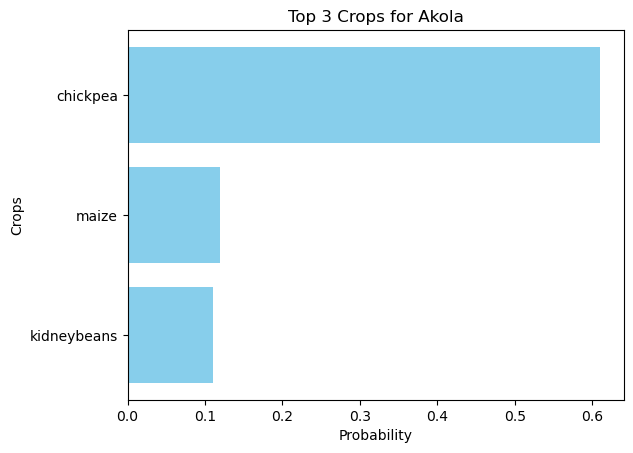

In [3]:
import matplotlib.pyplot as plt

def plot_top_crops(top_crops, district_name):
    crops, probs = zip(*top_crops)
    plt.barh(crops, probs, color='skyblue')
    plt.xlabel("Probability")
    plt.ylabel("Crops")
    plt.title(f"Top 3 Crops for {district_name.capitalize()}")
    plt.gca().invert_yaxis()
    plt.show()

# Call this function after prediction
if not isinstance(top_crops, str):  # If crops are predicted successfully
    plot_top_crops(top_crops, district_name_input)


In [4]:
import joblib
joblib.dump(rf_model, 'crop_prediction_model.pkl')

['crop_prediction_model.pkl']

In [5]:
import pickle

# Save the LabelEncoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
